[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thrash-lab/sparse-growth-curve/blob/main/1_one_growth_curve_analysis.ipynb)

[![License: MIT](https://img.shields.io/badge/License-MIT-yellow.svg)](https://opensource.org/licenses/MIT) for the code.

[![License: CC BY-NC 4.0](https://img.shields.io/badge/License-CC%20BY--NC%204.0-lightgrey.svg)](https://creativecommons.org/licenses/by-nc/4.0/) for other contents.

#### **Authors**: Chuankai Cheng and J. Cameron Thrash(*)

Department of Biological Sciences, University of Southern California, Los Angeles, CA, USA




#### (*) Correspondence: J. Cameron Thrash
- University of Southern California
- 3616 Trousdale Pkwy, AHF 209
- Los Angeles, CA 90089, USA
- thrash@usc.edu

In [2]:
#package for numerical analysis: numpy
import numpy as np 
#package for plotting: plt
from matplotlib import pyplot as plt

#statistical analysis
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression,RANSACRegressor
from scipy import stats

#methods for 1-D interpolation: interp1d 
from scipy.interpolate import interp1d

# All the customized functions that are needed:
- Linear regression with 95% confidence band: myLinearRegression_CB

In [3]:
def myLinearRegression_CB(x, y, x_fit, one_order=10):
  print('\nFitting data:')
  print('x = ', x)
  print('y = ', y)

  corr=np.corrcoef(x,y)[0][1]
  print('|corr|=', np.abs(corr))

  if (((np.abs(corr)<0.80) or (len(y)<4)) and 
      ((np.abs(corr)<0.90) or (len(y)<3)) and
      ((np.max(y)-np.min(y))<np.log2(one_order))):
    comp_y=np.median(y)*np.ones(len(y))
    pre_y=np.median(y)*np.ones(len(x_fit))
    doubling_rate=1e-6
  
  else:
    #Robust linear model estimation using RANSAC
    X=x.reshape(-1,1)
    if len(y)>4:
      try: 
        reg = RANSACRegressor()
        reg.fit(X, y)
        doubling_rate=reg.estimator_.coef_[0]
        inlier_mask = reg.inlier_mask_
        outlier_mask = np.logical_not(inlier_mask)
        
      except ValueError:
        print('RANSAC could not find a valid consensus set.\n',
              'Running regular linear regression.')
        reg = LinearRegression()
        reg.fit(X,y)
        doubling_rate=reg.coef_[0]
    else:
        reg = LinearRegression()
        reg.fit(X,y)
        doubling_rate=reg.coef_[0]
    
    pre_y=reg.predict(x_fit.reshape(-1,1))
    comp_y=reg.predict(X)
  
  sigma=np.sqrt(
      np.sum(
          (comp_y-y)**2
          /
          (len(x)-1))
      )

  T_95 = stats.t.ppf(0.95, len(x)-1)

  G=np.sqrt(
      1/len(x)
      +
      (x_fit-np.mean(x))**2
      /
      sum((x-np.mean(x))**2)
      )

  ci=sigma*T_95*G
  
  #sigma**2/np.sum()

  return (doubling_rate, pre_y, ci)

# Import the growth curve data and plot

In [4]:
# import the growth curve data: time and cell density 
# (the two arrays need to be in the same length)
time=np.array([  0.   ,  17.75 ,  24.   ,  42.5  ,  47.17 ,  65.75 ,  71.5  ,
        88.5  ,  95.33 , 160.33 , 167.497]
        )

cell_density=np.array([8445.6, 512116.9, 3801502, 437134, 4105945,
                       3518974, 3245031, 3368960, 3362095, 2628343,
                       2654070])

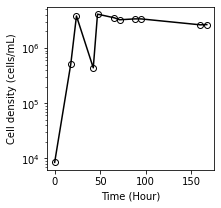

In [5]:
%matplotlib inline
plt.figure(figsize=(3,3))

#'k' means black, 'o' means circle
# mfc='none' means empty shape
plt.plot(time, cell_density,
         'o-',
         color='k',
         mfc='none')

plt.xlabel('Time (Hour)')
plt.ylabel('Cell density (cells/mL)')
plt.yscale('log')

plt.savefig('./1_growth_curve.pdf')
plt.show()

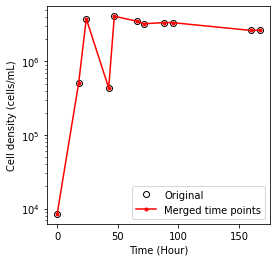

In [6]:
t=time
X=cell_density

t1=np.array(t)
X1=np.array(X)

t_o=np.array(t)
X_o=np.array(X)
#for i in range(len(t)-3):
#  t1=np.r_[t1,np.median(t[[i,i+1,i+2]])]
#  X1=np.r_[X1, np.median(X[[i,i+1, i+2]])]


#You might get multiple cell counts for the same sample at one time.
#In my example, I have two cell counts on day 15.
#Here, I merge the cell densities by their mean:

#using the function "np.unique"
#I get rid of the duplicated time points
t=np.unique(t1) 

X=[]
for tt in np.unique(t1):
  temporary_cell_densities=X1[t1==tt]
  #Getting the mean cell density at a time point
  X.append(np.median(temporary_cell_densities))
X=np.array(X)

X=X[np.argsort(t)]
t=t[np.argsort(t)]

%matplotlib inline
plt.figure(figsize=(4,4))

#'k' means black, 'o' means circle
# mfc='none' means empty shape
plt.plot(time, cell_density,
         'o',
         color='k',
         mfc='none', 
         label='Original')

#'r' means red, 
#'.-' means connected dot
plt.plot(t, X,
         '.-',
         color='r',
         label='Merged time points')

plt.legend()
plt.xlabel('Time (Hour)')
plt.ylabel('Cell density (cells/mL)')
plt.yscale('log')

plt.savefig('./2_growth_curve_time_merged.pdf')

plt.show()

# Get the "instataneous" doubling rates

Assuming that our growth curve is $X(t)$. The "instataneous" doubling rate $\gamma (t)$ can then be calculated as:

## $\gamma (t)=\frac{\mathrm{d}\ \mathrm{log_2}(X(t))}{\mathrm{d}\ t}$ 

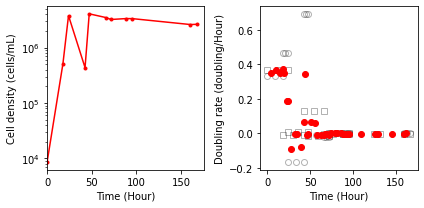

In [7]:
%matplotlib inline

gamma=np.diff(np.log2(X))/np.diff(t)
gamma=np.r_[gamma, gamma, gamma]
#gamma=np.r_[gamma[0], gamma]
t_gamma=np.r_[t[0:-1],
              np.array([(t[i]+t[i+1])/2 for i in range(len(t)-1)]),
              t[1::]]

gamma_2=np.diff(np.log2(X)[::2])/np.diff(t[::2])
gamma_2=np.r_[gamma_2, gamma_2, gamma_2]
t_gamma_2=np.r_[t[::2][0:-1],
                [(t[::2][i]+t[::2][i+1])/2 for i in range(len(t[::2])-1)],
                t[::2][1::]]

gamma_2_1=np.diff(np.log2(X)[1::2])/np.diff(t[1::2])
gamma_2_1=np.r_[gamma_2_1, gamma_2_1, gamma_2_1]
t_gamma_2_1=np.r_[t[1::2][0:-1],
                [(t[1::2][i]+t[1::2][i+1])/2 for i in range(len(t[1::2])-1)],
                t[1::2][1::]]


#gamma_3=np.diff(np.log2(X)[::3])/np.diff(t[::3])
#gamma_3=np.r_[gamma_3, gamma_3, gamma_3]
#t_gamma_3=np.r_[t[::3][0:-1],
#                [(t[::3][i]+t[::3][i+1])/2 for i in range(len(t[::3])-1)],
#                t[::3][1::]]

plt.figure(figsize=(6,3))

plt.subplot(121)
plt.plot(t, X, 'r.-')

plt.xlim(left=0)
plt.yscale('log')
plt.xlabel('Time (Hour)')
plt.ylabel('Cell density (cells/mL)')

plt.subplot(122)
plt.plot(t_gamma, 
         gamma, 
         'ko', mfc='none', alpha=0.3)

plt.plot(t_gamma_2, 
         gamma_2, 
         'ks', mfc='none', alpha=0.3)

plt.plot(t_gamma_2_1, 
         gamma_2_1, 
         'ks', mfc='none', alpha=0.3)

#plt.plot(t_gamma_3, 
#         gamma_3, 
#         'k^',mfc='none', alpha=0.3)

all_t_gamma=np.r_[t_gamma,t_gamma_2, t_gamma_2_1]
all_gamma=np.r_[gamma, gamma_2, gamma_2_1]

all_gamma=all_gamma[np.argsort(all_t_gamma)]
all_t_gamma=np.sort(all_t_gamma)

all_gamma=np.array([np.median(all_gamma[[i,i+1,i+2,i+3]]) 
                    for i in range(len(all_t_gamma)-4)])
all_t_gamma=np.array([np.median(all_t_gamma[[i,i+1,i+2,i+3]]) 
                    for i in range(len(all_t_gamma)-4)])

sel_t_gamma=np.unique(all_t_gamma)
sel_gamma=[]
for stg in sel_t_gamma:
  sel_gamma.append(
      np.median(all_gamma[all_t_gamma==stg]))
sel_gamma=np.array(sel_gamma)

plt.plot(sel_t_gamma, sel_gamma, 'ro')
#plt.xlim(left=0)

plt.xlabel('Time (Hour)')
plt.ylabel('Doubling rate (doubling/Hour)')

plt.tight_layout()

plt.savefig('./3_growth_curve_doubling_rates.pdf')
plt.show()

# Fitting the growth curve

Based on the growth curve and the instataneous growth rates showing above, we want to separate different phases (lag, exponential, and stationary). We also want to do this automatically.

- Here, we use the method called "DecisionTreeRegressor"
- More about DecisionTreeRegressor: https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html#sphx-glr-auto-examples-tree-plot-tree-regression-py

In [8]:
# The max_depth here I set is 1
# Because for a standard growth curve (no diauxic shift) without death phase,
# there would only be two states:
# 1. Not growing (lag phase and stationary), growth rate is close to 0;
# 2. Growing exponentially at an almost constant rate.

regr_1 = DecisionTreeRegressor(max_depth=1)
regr_1.fit(sel_t_gamma.reshape(-1, 1), 
           sel_gamma)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=1,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

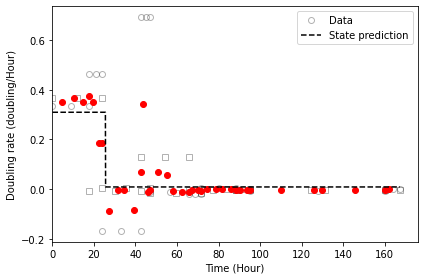

In [9]:
%matplotlib inline

t_1 = np.arange(0.0, t[-1], 0.1)[:, np.newaxis]
gamma_1 = regr_1.predict(t_1)

plt.plot(t_gamma, 
         gamma, 
         'ko', mfc='none', label='Data', alpha=0.3)

plt.plot(t_gamma_2, 
         gamma_2, 
         'ks', mfc='none', alpha=0.3)

plt.plot(t_gamma_2_1, 
         gamma_2_1, 
         'ks', mfc='none', alpha=0.3)

plt.plot(sel_t_gamma, sel_gamma, 'ro')

plt.plot(t_1, 
         gamma_1, 
         'k--', label='State prediction')

plt.xlim(left=0)

plt.xlabel('Time (Hour)')
plt.ylabel('Doubling rate (doubling/Hour)')

plt.legend()

plt.savefig('4_state_prediction.pdf')
plt.tight_layout()

The prediction plot above shows that the algorithm estimated 0--25 hours as one phase (**presumably** the exponential phase). After 25 hours would be another phase (**presumably** the stationary phase). Perhaps due to the short lag period, the prediction does not return a lag phase.
- We use the word **presumably** because we want the software to determine the exponential phase later (this is non-trivial).
- Also, even though the state predictions gave their estimation of doubling rates: 0.3 doubling/hour between 0 and 25 hours, 0.01 doubling/hour between 25 and 170 hours, we want the doubling rates be recalculated through **linear regressions**.

In [10]:
#First, we find the state transition point
gamma_1_diff=np.diff(gamma_1)
inflection_points=t_1[1::][gamma_1_diff!=0]

print(inflection_points)

[[25.6]]


In [11]:
all_starting_time=np.r_[[0],inflection_points.reshape(1,-1)[0], t_1[-1]]
print(all_starting_time)

[  0.   25.6 167.4]


Here, we have the starting time as 0 hours, 25.6 hours, and 167.4 hours, which means we will be doing linear regressions for **two periods**:
- 0 to 25.6 hours
- 25.6 to 167.4 hours

In [12]:
all_doubling_rates=[]
all_fit_time=[]
all_fit_cell_density=[]
all_fit_conf_band=[]

for i in range(len(all_starting_time)-1):
  start_t=all_starting_time[i]
  end_t=all_starting_time[i+1]

  print('Time period: ', start_t, 'hours  ---', end_t, 'hours')

  # Chooseing the time period:
  sel_bool=(t>=start_t-1) & (t<=end_t+1)
  #if np.sum(sel_bool)<3:
  #  if np.where(sel_bool)[0][0]!=0 and np.where(sel_bool)[0][-1]!=len(sel_bool)-1:
  #    sel_bool[np.where(sel_bool)[0][0]-1]=True
  #    #sel_bool[np.where(sel_bool)[0][-1]+1]=True
  #  elif np.where(sel_bool)[0][0]!=0:
  #    sel_bool[np.where(sel_bool)[0][0]-1]=True
  #  elif np.where(sel_bool)[0][-1]!=len(sel_bool)-1:
  #    sel_bool[np.where(sel_bool)[0][-1]+1]=True

  if np.sum(sel_bool)>=2:
    sel_t=t[sel_bool]
    sel_X=X[sel_bool]

    #print(sel_t, sel_X)

    fit_bool=(t_1>=start_t-1) & (t_1<=end_t+1)
    sel_t_1=t_1[fit_bool]

    (dr, pre_X_1, ci)=myLinearRegression_CB(
        sel_t, 
        np.log2(sel_X), 
        sel_t_1)
    
    all_doubling_rates.append(dr)
    all_fit_time.append(sel_t_1)
    all_fit_cell_density.append(2**pre_X_1)
    all_fit_conf_band.append(2**ci)

    print('Doubling rate:', dr, 'doubling/hour')
    print('\n')

  else:
    print('No data point in this time period, not fitting.')

Time period:  0.0 hours  --- 25.6 hours

Fitting data:
x =  [ 0.   17.75 24.  ]
y =  [13.0439842  18.96611364 21.85813812]
|corr|= 0.9972659600681799
Doubling rate: 0.35987920384111155 doubling/hour


Time period:  25.6 hours  --- 167.4 hours

Fitting data:
x =  [ 42.5    47.17   65.75   71.5    88.5    95.33  160.33  167.497]
y =  [18.73771607 21.96928287 21.74672342 21.62980083 21.68387187 21.68092906
 21.32572213 21.33977499]
|corr|= 0.23856032171274993
Doubling rate: 1e-06 doubling/hour




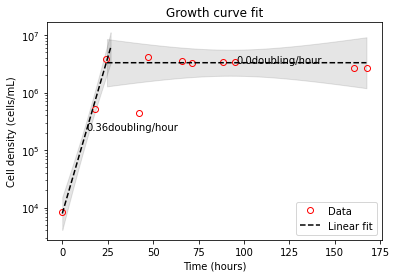

In [13]:
%matplotlib inline

plt.plot(t, X, 'ro', mfc='none', label='Data')

for i in range(len(all_doubling_rates)):
  if i==0:
    plt.plot(all_fit_time[i], all_fit_cell_density[i], 'k--',
            label='Linear fit')
  else:
    plt.plot(all_fit_time[i], all_fit_cell_density[i], 'k--',
            label='_nolegend_')
    
  plt.fill_between(all_fit_time[i], 
                   all_fit_cell_density[i]*all_fit_conf_band[i],
                   all_fit_cell_density[i]/all_fit_conf_band[i],
                   color='k', alpha=0.1)
      
  plt.text(np.median(all_fit_time[i]), 
           2**np.median(np.log2(all_fit_cell_density[i])),
           str(np.round(all_doubling_rates[i],2))+'doubling/hour')

plt.xlabel('Time (hours)')
plt.ylabel('Cell density (cells/mL)')
plt.yscale('log')
plt.title('Growth curve fit')
plt.legend(loc=4)

plt.savefig('5_growth_curve_fit.pdf')
plt.show()

# Which phase is the exponential phase?

We designed the algorithm to define the phase that crosses the most orders of magnitude as the exponential phase.

In [14]:
all_acrossing_orders=[]
for i in range(len(all_fit_cell_density)):
  start_t=all_fit_time[i][0]
  end_t=all_fit_time[i][-1]

  print('Time period: ', start_t, 'hours  ---', end_t, 'hours')

  afc = all_fit_cell_density[i]
  acrossing_orders=np.log10(afc[-1])-np.log10(afc[0])
  all_acrossing_orders.append(acrossing_orders)
  
  print('Doubling rate:', all_doubling_rates[i], 'doubling/hour')
  print('Number of orders acrossing:', acrossing_orders)
  print('\n')

Time period:  0.0 hours  --- 26.6 hours
Doubling rate: 0.35987920384111155 doubling/hour
Number of orders acrossing: 2.881695975571125


Time period:  24.6 hours  --- 167.4 hours
Doubling rate: 1e-06 doubling/hour
Number of orders acrossing: 0.0




In [15]:
selected_i=np.argmax(all_acrossing_orders)
selected_doubling_rate=all_doubling_rates[selected_i]
selected_fit_time=all_fit_time[selected_i]
selected_fit_cell_density=all_fit_cell_density[selected_i]

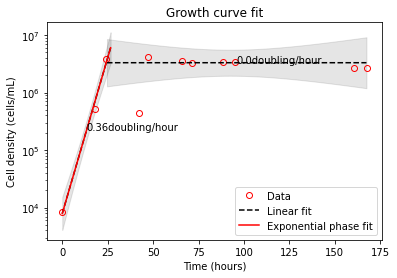

In [16]:
%matplotlib inline

plt.plot(t_o, X_o, 'ro', mfc='none', label='Data')

for i in range(len(all_doubling_rates)):
  if i==0:
    plt.plot(all_fit_time[i], all_fit_cell_density[i], 'k--',
            label='Linear fit')
  else:
    plt.plot(all_fit_time[i], all_fit_cell_density[i], 'k--',
            label='_nolegend_')
    
  plt.fill_between(all_fit_time[i], 
                   all_fit_cell_density[i]*(all_fit_conf_band[i]),
                   all_fit_cell_density[i]/(all_fit_conf_band[i]),
                   color='k', alpha=0.1)
    
  plt.text(np.median(all_fit_time[i]), 
           2**np.median(np.log2(all_fit_cell_density[i])),
           str(np.round(all_doubling_rates[i],2))+'doubling/hour')

plt.plot(selected_fit_time, selected_fit_cell_density,'r-',
         label='Exponential phase fit')
plt.xlabel('Time (hours)')
plt.ylabel('Cell density (cells/mL)')
plt.yscale('log')
plt.title('Growth curve fit')
plt.legend()

plt.savefig('6_exponential_phase.pdf')
plt.show()

In [17]:
print('The doubling rate for exponential phase is:', 
      selected_doubling_rate, 'doubling/hour', '\n')

print('The doubling time is:',
      1/selected_doubling_rate, 'hour/doubling','\n')

print('Converting to specific growth rate, we have:',
      np.log(2)*selected_doubling_rate, 'doubling/hour', '\n')

The doubling rate for exponential phase is: 0.35987920384111155 doubling/hour 

The doubling time is: 2.7787101597610095 hour/doubling 

Converting to specific growth rate, we have: 0.2494492554846243 doubling/hour 



# Wrapping up the code in a function.

In [18]:
def preprocessing_growth_curve(time, cell_density):
  """
  :Authors:
    Chuankai Cheng <chuankai@usc.edu> and J. Cameron Thrash <thrash@usc.edu>
  :License:
    MIT
  :Version:
    1.0
  :Date:
    2021-03-17
  :Repository: https://github.com/thrash-lab/sparse-growth-curve
  """
  t=np.array(time)
  X=np.array(cell_density)

  #for i in range(len(time)-3):
  #  t=np.r_[t,np.median(time[[i,i+1,i+2]])]
  #  X=np.r_[X, np.median(cell_density[[i,i+1, i+2]])]

  X=X[np.argsort(t)]
  t=t[np.argsort(t)]

  #You might get multiple cell counts for the same sample at one time.
  #Here, I merge the cell densities by their mean:
  #using the function "np.unique"
  #I get rid of the duplicated time points
  t1=np.unique(t) 
  X1=[]
  for tt in t1:
    temporary_cell_densities=X[t==tt]
    #Getting the mean cell density at a time point
    X1.append(np.median(temporary_cell_densities))
  X1=np.array(X1)

  return t1, X1

In [19]:
def phase_seperations(t, X, max_depth=1):
  """
  :Authors:
    Chuankai Cheng <chuankai@usc.edu> and J. Cameron Thrash <thrash@usc.edu>
  :License:
    MIT
  :Version:
    1.0
  :Date:
    2021-03-17
  :Repository: https://github.com/thrash-lab/sparse-growth-curve
  """
  gamma=np.diff(np.log2(X))/np.diff(t)
  gamma=np.r_[gamma, gamma, gamma]
  #gamma=np.r_[gamma[0], gamma]
  t_gamma=np.r_[t[0:-1],
                np.array([(t[i]+t[i+1])/2 for i in range(len(t)-1)]),
                t[1::]]

  gamma_2=np.diff(np.log2(X)[::2])/np.diff(t[::2])
  gamma_2=np.r_[gamma_2, gamma_2, gamma_2]
  t_gamma_2=np.r_[t[::2][0:-1],
                  [(t[::2][i]+t[::2][i+1])/2 for i in range(len(t[::2])-1)],
                  t[::2][1::]]


  gamma_2_1=np.diff(np.log2(X)[1::2])/np.diff(t[1::2])
  gamma_2_1=np.r_[gamma_2_1, gamma_2_1, gamma_2_1]
  t_gamma_2_1=np.r_[t[1::2][0:-1],
                  [(t[1::2][i]+t[1::2][i+1])/2 for i in range(len(t[1::2])-1)],
                  t[1::2][1::]]


  #gamma_3=np.diff(np.log2(X)[::3])/np.diff(t[::3])
  #gamma_3=np.r_[gamma_3, gamma_3, gamma_3]
  #t_gamma_3=np.r_[t[::3][0:-1],
  #                [(t[::3][i]+t[::3][i+1])/2 for i in range(len(t[::3])-1)],
  #                t[::3][1::]]

  all_t_gamma=np.r_[t_gamma,t_gamma_2, t_gamma_2_1]
  all_gamma=np.r_[gamma, gamma_2, gamma_2_1]

  all_gamma=all_gamma[np.argsort(all_t_gamma)]
  all_t_gamma=np.sort(all_t_gamma)

  all_gamma=np.array([np.median(all_gamma[[i,i+1,i+2,i+3]]) 
                      for i in range(len(all_t_gamma)-4)])
  all_t_gamma=np.array([np.median(all_t_gamma[[i,i+1,i+2,i+3]]) 
                      for i in range(len(all_t_gamma)-4)])

  sel_t_gamma=np.unique(all_t_gamma)
  sel_gamma=[]
  for stg in sel_t_gamma:
    sel_gamma.append(
        np.mean(all_gamma[all_t_gamma==stg]))
  sel_gamma=np.array(sel_gamma)

  #print(sel_gamma)
  #print(sel_t_gamma)
  # By default, max_depth = 1
  # Because for a standard growth curve (no diauxic shift) without death phase,
  # there would only be two states:
  # 1. Not growing (lag phase and stationary), growth rate is close to 0;
  # 2. Growing exponentially at an almost constant rate.

  regr_1 = DecisionTreeRegressor(max_depth=max_depth)
  regr_1.fit(sel_t_gamma.reshape(-1, 1), sel_gamma)

  t_fit = np.arange(0.0, t[-1], 0.01)[:, np.newaxis]
  gamma_fit = regr_1.predict(t_fit)

  #print(gamma_fit)
  #We find the state transition point
  gamma_fit_diff=np.diff(gamma_fit)
  inflection_points=t_fit[1::][gamma_fit_diff!=0]

  all_starting_time=np.r_[[0],inflection_points.reshape(1,-1)[0], t_fit[-1]]

  return all_starting_time

In [20]:
def phases_exponential_fit(phases_points, t, X, one_order):
  """
  :Authors:
    Chuankai Cheng <chuankai@usc.edu> and J. Cameron Thrash <thrash@usc.edu>
  :License:
    MIT
  :Version:
    1.0
  :Date:
    2021-03-17
  :Repository: https://github.com/thrash-lab/sparse-growth-curve
  """
  all_starting_time=phases_points

  all_doubling_rates=[]
  all_fit_time=[]
  all_fit_cell_density=[]
  all_fit_conf_band=[]

  print('All phases points', all_starting_time)
  t_1 = np.arange(0.0, t[-1], 0.01)[:, np.newaxis]
  
  for i in range(len(all_starting_time)-1):
    start_t=all_starting_time[i]
    end_t=all_starting_time[i+1]

    #print('Time period: ', start_t, 'hours  ---', end_t, 'hours')
    # Chooseing the time period:
    sel_bool=(t>=start_t-1) & (t<=end_t+1)
    #if np.sum(sel_bool)<3:
    #  if np.where(sel_bool)[0][0]!=0 and np.where(sel_bool)[0][-1]!=len(sel_bool)-1:
    #    sel_bool[np.where(sel_bool)[0][0]-1]=True
    #    sel_bool[np.where(sel_bool)[0][-1]+1]=True
    #  elif np.where(sel_bool)[0][0]!=0:
    #    sel_bool[np.where(sel_bool)[0][0]-1]=True
    #  elif np.where(sel_bool)[0][-1]!=len(sel_bool)-1:
    #    sel_bool[np.where(sel_bool)[0][-1]+1]=True

    if np.sum(sel_bool)>=2:
      sel_t=t[sel_bool]
      sel_X=X[sel_bool]

      #print(sel_t, sel_X)

      fit_bool=(t_1>=start_t-1) & (t_1<=end_t+1)
      sel_t_1=t_1[fit_bool]

      (dr, pre_X_1, ci)=myLinearRegression_CB(
          sel_t, 
          np.log2(sel_X), 
          sel_t_1)
      
      all_doubling_rates.append(dr)
      all_fit_time.append(sel_t_1)
      all_fit_cell_density.append(2**pre_X_1)
      all_fit_conf_band.append(2**ci)

      print('Doubling rate:', dr, 'doubling/hour')
      print('\n')

    else:
      print('No data point in this time period, not fitting.')

  return (all_doubling_rates,
            all_fit_time,
            all_fit_cell_density,
            all_fit_conf_band)

In [21]:
def growth_death_rate_decision(all_fit_cell_density,
                               all_fit_time,
                               all_doubling_rates):
  """
  :Authors:
    Chuankai Cheng <chuankai@usc.edu> and J. Cameron Thrash <thrash@usc.edu>
  :License:
    MIT
  :Version:
    1.0
  :Date:
    2021-03-17
  :Repository: https://github.com/thrash-lab/sparse-growth-curve
  """
  #all_starting_time=phases_points
  all_acrossing_orders=[]
  for i in range(len(all_fit_cell_density)):
    start_t=all_fit_time[i][0]
    end_t=all_fit_time[i][-1]

    print('\nTime period: ', start_t, 'hours  ---', end_t, 'hours')

    afc = all_fit_cell_density[i]
    acrossing_orders=np.log10(afc[-1])-np.log10(afc[0])
    all_acrossing_orders.append(acrossing_orders)
    
    print('Doubling rate:', all_doubling_rates[i], 'doubling/hour')
    print('Number of orders acrossing:', acrossing_orders)

  selected_doubling_rate=0
  selected_fit_time=0
  selected_fit_cell_density=all_fit_cell_density[0][0]

  selected_doubling_rate_d=0
  selected_fit_time_d=all_fit_time[-1][-1]
  selected_fit_cell_density_d=all_fit_cell_density[-1][-1]

  #Growth phase:
  if max(all_acrossing_orders)>0:
    selected_i=np.argmax(all_acrossing_orders)
    selected_doubling_rate=all_doubling_rates[selected_i]
    selected_fit_time=all_fit_time[selected_i]
    selected_fit_cell_density=all_fit_cell_density[selected_i]

  #Death phase:
  if min(all_acrossing_orders)<0:
    selected_i_d=np.argmin(all_acrossing_orders)
    selected_doubling_rate_d=all_doubling_rates[selected_i_d]
    selected_fit_time_d=all_fit_time[selected_i_d]
    selected_fit_cell_density_d=all_fit_cell_density[selected_i_d]

  return (selected_doubling_rate,
          selected_fit_time,
          selected_fit_cell_density,
          selected_doubling_rate_d,
          selected_fit_time_d,
          selected_fit_cell_density_d)

In [22]:
def fit_growth_curve(time, cell_density, one_order=10, decision_tree_depth=1):
  """
  :Authors:
    Chuankai Cheng <chuankai@usc.edu> and J. Cameron Thrash <thrash@usc.edu>
  :License:
    MIT
  :Version:
    1.0
  :Date:
    2021-03-17
  :Repository: https://github.com/thrash-lab/sparse-growth-curve
  """
  t1,X1=preprocessing_growth_curve(time, cell_density)
  phases_points=phase_seperations(t1, X1, max_depth=decision_tree_depth)

  print(phases_points)
  
  (all_doubling_rates,
            all_fit_time,
            all_fit_cell_density,
            all_fit_conf_band)=phases_exponential_fit(phases_points, t1, X1, 
                                                 one_order)

  (selected_doubling_rate,
          selected_fit_time,
          selected_fit_cell_density,
          selected_doubling_rate_d,
          selected_fit_time_d,
          selected_fit_cell_density_d)=growth_death_rate_decision(
                               all_fit_cell_density,
                               all_fit_time,
                               all_doubling_rates)
          
  return (all_fit_time,
          all_fit_cell_density,
          all_fit_conf_band,
          selected_doubling_rate,
          selected_fit_time,
          selected_fit_cell_density,
          selected_doubling_rate_d,
          selected_fit_time_d,
          selected_fit_cell_density_d)

In [23]:
(all_fit_time,
          all_fit_cell_density,
          all_fit_conf_band,
          selected_doubling_rate,
          selected_fit_time,
          selected_fit_cell_density,
          selected_doubling_rate_d,
          selected_fit_time_d,
          selected_fit_cell_density_d)=fit_growth_curve(
              time, cell_density, one_order=10, decision_tree_depth=1)

[  0.    23.22 167.49]
All phases points [  0.    23.22 167.49]

Fitting data:
x =  [ 0.   17.75 24.  ]
y =  [13.0439842  18.96611364 21.85813812]
|corr|= 0.9972659600681799
Doubling rate: 0.35987920384111155 doubling/hour



Fitting data:
x =  [ 24.     42.5    47.17   65.75   71.5    88.5    95.33  160.33  167.497]
y =  [21.85813812 18.73771607 21.96928287 21.74672342 21.62980083 21.68387187
 21.68092906 21.32572213 21.33977499]
|corr|= 0.11789908631115496
Doubling rate: 1e-06 doubling/hour



Time period:  0.0 hours  --- 24.22 hours
Doubling rate: 0.35987920384111155 doubling/hour
Number of orders acrossing: 2.6238600198621302

Time period:  22.22 hours  --- 167.49 hours
Doubling rate: 1e-06 doubling/hour
Number of orders acrossing: 0.0


In [24]:
def fit_growth_curve_ransac_method(time, cell_density):
  """
  :Authors:
    Chuankai Cheng <chuankai@usc.edu> and J. Cameron Thrash <thrash@usc.edu>
  :License:
    MIT
  :Version:
    1.0
  :Date:
    2021-03-17
  :Repository: https://github.com/thrash-lab/sparse-growth-curve
  """
  outlier_mask=np.array([True for i in range(len(cell_density))])
  t_ransac=time[outlier_mask]
  cd_ransac=cell_density[outlier_mask]

  all_ransac_periods=[]
  all_ransac_periods_cd=[]
  all_ransac_periods_order=[]
  all_ransac_periods_doubling_rate=[]
  p=1
  while len(t_ransac)>2:
    reg = RANSACRegressor()
    reg.fit(t_ransac.reshape(-1,1), np.log2(cd_ransac))
    inlier_mask = reg.inlier_mask_

    print('\nPeriod', p, ':')
    cd_fit=2**(reg.predict(t_ransac[inlier_mask].reshape(-1,1)))

    all_ransac_periods.append(t_ransac[inlier_mask])
    all_ransac_periods_cd.append(cd_fit)

    print('Time=', t_ransac[inlier_mask], 
          '\nCell density=', cd_ransac[inlier_mask], 
          '\nFit cell density=', cd_fit)
    print('Doubling rate=', reg.estimator_.coef_[0], 'Doubling/hour')
    orders=np.log10(cd_fit[-1]/cd_fit[0])
    print('Orders acorssing=', orders)
    all_ransac_periods_doubling_rate.append(reg.estimator_.coef_[0])
    all_ransac_periods_order.append(orders)

    outlier_mask = np.logical_not(inlier_mask)
    
    t_ransac=t_ransac[outlier_mask]
    cd_ransac=cd_ransac[outlier_mask]

    p+=1

  ransac_selected_doubling_rate=all_ransac_periods_doubling_rate[np.argmax(all_ransac_periods_order)]
  ransac_selected_doubling_rate_d=all_ransac_periods_doubling_rate[np.argmin(all_ransac_periods_order)]

  ransac_selected_periods=all_ransac_periods[np.argmax(all_ransac_periods_order)]
  ransac_selected_periods_d=all_ransac_periods[np.argmin(all_ransac_periods_order)]

  ransac_selected_periods_cd=all_ransac_periods_cd[np.argmax(all_ransac_periods_order)]
  ransac_selected_periods_cd_d=all_ransac_periods_cd[np.argmin(all_ransac_periods_order)]
  
  return (all_ransac_periods,
          all_ransac_periods_cd,
          all_ransac_periods_order,
          all_ransac_periods_doubling_rate,
          ransac_selected_doubling_rate,
          ransac_selected_doubling_rate_d,
          ransac_selected_periods,
          ransac_selected_periods_d,
          ransac_selected_periods_cd,
          ransac_selected_periods_cd_d)

In [25]:
(all_ransac_periods,
          all_ransac_periods_cd,
          all_ransac_periods_order,
          all_ransac_periods_doubling_rate,
          ransac_selected_doubling_rate,
          ransac_selected_doubling_rate_d,
          ransac_selected_periods,
          ransac_selected_periods_d,
          ransac_selected_periods_cd,
          ransac_selected_periods_cd_d)=fit_growth_curve_ransac_method(time, cell_density)


Period 1 :
Time= [ 24.     47.17   65.75   71.5    88.5    95.33  160.33  167.497] 
Cell density= [3801502. 4105945. 3518974. 3245031. 3368960. 3362095. 2628343. 2654070.] 
Fit cell density= [4000712.13634556 3739475.47832588 3542368.25295025 3483500.25299035
 3315115.72353293 3249779.24425836 2688947.93209049 2633364.7276649 ]
Doubling rate= -0.004204613851878815 Doubling/hour
Orders acorssing= -0.18162628951290202

Period 2 :
Time= [ 0.   17.75] 
Cell density= [  8445.6 512116.9] 
Fit cell density= [  8445.6 512116.9]
Doubling rate= 0.33364109515847695 Doubling/hour
Orders acorssing= 1.7827385993626594


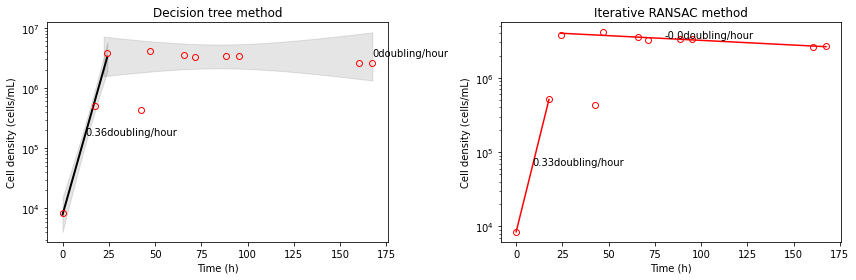

In [26]:
%matplotlib inline
plt.figure(figsize=(12,4))

plt.subplot(121)
for i in range(len(all_fit_time)):
  #plt.plot(all_fit_time[i], all_fit_cell_density[i], 'k--')
  plt.fill_between(all_fit_time[i], 
                   all_fit_cell_density[i]*(all_fit_conf_band[i]),
                   all_fit_cell_density[i]/(all_fit_conf_band[i]),
                   color='k', alpha=0.1)
  
plt.plot(selected_fit_time, selected_fit_cell_density, 'k-',
         linewidth=2)

plt.text(np.median(selected_fit_time), 
           2**np.median(np.log2(selected_fit_cell_density)),
           str(np.round(selected_doubling_rate,2))+'doubling/hour')

plt.plot(selected_fit_time_d, selected_fit_cell_density_d, 'k--', 
         linewidth=2)

plt.text(np.median(selected_fit_time_d), 
           2**np.median(np.log2(selected_fit_cell_density_d)),
           str(np.round(selected_doubling_rate_d,2))+'doubling/hour')

plt.plot(time, cell_density, 'ro', mfc='none')


plt.xlabel('Time (h)')
plt.ylabel('Cell density (cells/mL)')

plt.yscale('log')
plt.title('Decision tree method')

plt.subplot(122)
for i in range(len(all_ransac_periods)):
  plt.plot(all_ransac_periods[i], all_ransac_periods_cd[i], 'r-')
  plt.text(np.median(all_ransac_periods[i]),
           2**np.median(np.log2(all_ransac_periods_cd[i])),
           str(np.round(all_ransac_periods_doubling_rate[i],2))+'doubling/hour')
  
  
plt.plot(time, cell_density, 'ro', mfc='none')


plt.xlabel('Time (h)')
plt.ylabel('Cell density (cells/mL)')

plt.yscale('log')
plt.title('Iterative RANSAC method')

plt.tight_layout()

plt.savefig('Methods_comparison.pdf')
plt.show()